# Final exam

**Note:** Use these guidelines if and only if you are taking the **final exam**. If you are working on a **final project of your own design**, see the (separate) final project guidelines.

## Guidelines

This exam is for **undergraduates enrolled in INFO 3350**. If you are a graduate student enrolled in INFO 6350, you must complete a final project of your own design.

### The task

Your task is to: identify an interesting problem that's addressable with the help of computational methods applied to the supplied corpus, formulate a hypothesis about that problem, devise an experiment or experiments to test your hypothesis, present the results of your investigations, and discuss your findings.

This workflow essentially replicates the process of writing an academic paper. You can think of your exam as a paper in miniature.

You are free to present each of these tasks as you see fit. You should use narrative text (that is, your own writing in a markdown cell), citations of others' work, numerical results, tables of data, and static and/or interactive visualizations as appropriate. Total length is flexible and depends on the number of people involved in the work, as well as the specific balance you strike between the ambition of your question and the sophistication of your methods. But be aware that numbers never, ever speak for themselves. Quantitative results presented without substantial discussion will not earn high marks. 

Your project should reflect, at minimum, ten **or more** hours of work, though you will be graded on the quality of your output, not the amount of time it took you to produce it. Most high-quality projects represent twenty or more hours of work.

#### Pick an important and interesting problem!

No amount of technical sophistication will overcome a fundamentally uninteresting problem at the core of your work. You have seen many pieces of successful computational humanities research over the course of the semester. You might use these as a guide to the kinds of problems that interest scholars in a range of humanities disciplines. You may also want to spend some time in the library, reading recent books and articles in the professional literature. **Problem selection and motivation are integral parts of the project.** Do not neglect them.

### The corpus

We have supplied you (via the course GitHub site) with a corpus of 1,540 volumes of American fiction published between 1789 and 1875, as well as a range of potentially relevant metadata. This corpus is large: it contains well over 100 million words. Some summary and descriptive statistics are included below, along with a short annotation of the metadata fields.

**Be aware that some (but certainly not all) text analysis tasks will be slow (or impossible) when run over a corpus as large as this one.** For comparison purposes, the subsampled album review dataset we used for homework 8 contained about 1% as many words (but a similar number of total documents). You might consider whether or not your question requires the use of the full corpus.

Books in the corpus are those that were included in volumes 1 and 2 of Lyle Wright's three-volume bibliography of American fiction before 1900 and that were digitized by the University of Virginia (1789-1850) and Indiana University (1851-1875). This corpus includes about 40% of the American fiction from the period (1789-1875) that has been preserved in American academic libraries. You might think a little about what kinds of books are most likely to have found their way first into print and then into academic libraries, and what kinds of books (and authors) might not have.

Metadata were collected manually by a team of undergraduate students at the University of Notre Dame.

**Note that the nineteenth century was awful.** These books reflect that fact in all kinds of ways, even though (or maybe because) they were generally considered unproblematic at the time. If you read the books or dig very far into the most informative features, you will quickly discover objectionable content. It would be valuable to devise (and you will be rewarded for devising) methods to avoid displaying unmasked versions of racial slurs, for example, in any visualization that might otherwise include them.

### Format

You should submit your exam as a report in the form of a Jupyter notebook that includes all code, figures, and write-up.

Your report should have four basic sections (provided in cells below for ease of reference and reuse):

1. **Introduction and hypothesis.** What problem are you working on? Why is it interesting and important? What have other people said about it? What do you expect to find?
2. **Corpus, data, and methods.** What data have you used? What are the limitations of that data? What major methods will you use to analyze it? Why are those methods the appropriate ones?
3. **Results.** What did you find? How did you find it? How should we read your figures? Be sure to include confidence intervals or other measures of statistical significance or uncetainty where appropriate.
4. **Discussion and conclusions.** What does it all mean? Do your results support your hypothesis? Why or why not? What are the limitations of your study and how might those limitations be addressed in future work?

Within each of those sections, you may use as many code and markdown cells as you like. You may, of course, address additional questions or issues not listed above. You may also gather additional data or metadata relevant to your analysis, but you are not required to do so.

All code used in the project should be present in the notebook (except for widely-available libraries that you import), but **be sure that we can read and understand your report in full without rerunning the code**. Unexecuted code will receive no credit. Be sure, too, to explain what you're doing along the way, both by describing your data and methods and by writing clean, well commented code.

### Grading

This exam is the take-home final for the course. It is worth 35% of your overall grade. You will be graded on the quality and ambition of each aspect of the project. No single component is more important than the others.

### Practical details

* The exam is due at **noon on Saturday, December 9** via upload of a single, fully executed Jupyter notebook file to CMS.
* **You must work alone.** You may not collaborate with others.
    * You may post questions on Ed, but should do so privately (visible to course staff only).
* Interactive visualizations do not always work when embedded in shared notebooks. If you plan to use interactives, you may need to host them elsewhere and link to them.

---

## Your info
* NetID(s): yz359
* Name(s): Amy Zhang
---

## 1. Introduction and hypothesis

## 2. Data and methods

In [116]:
# Imports
import os
os.environ['REQUESTS_CA_BUNDLE'] = ''
import pandas as pd
import spacy
from spacy.matcher import DependencyMatcher
from nltk.corpus import wordnet as wn
import nltk 
import json
import matplotlib.pyplot as plt
import numpy as np
from   sklearn.decomposition import PCA
from   sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from   sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import torch
from   matplotlib import ticker
import seaborn as sns
import random
from  collections import defaultdict
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif


In [36]:
!pip3 install transformers[torch]

zsh:1: no matches found: transformers[torch]


In [37]:
# File locations
#   Note that metadata are supplied as a TSV file
#   Text files are in a directory, one file per (long, novel-like) document
metadata_file = os.path.join('us_fiction', 'corpus_data.tsv')
text_dir      = os.path.join('us_fiction', 'us_texts')

In [38]:
# Load the metadata
metadata = pd.read_csv(
    metadata_file, 
    sep='\t',
    low_memory=False
).set_index('source_id')

### Corpus details
Before the investigation, we take a glance at the dataset provided.

In [39]:
# Glance at the metadata
metadata.head()

,author,title,pub_place,publisher,pub_date,gender,gender_guess,ethnicity,occupation,occupation_free,state_born,state_main,state_died,born,died,words
source_id,,,,,,,,,,,,,,,,
eaf001,"Allston, Washington",Monaldi,Boston,C. C. Little and J. Brown,1841,M,0.0,White,Arts,Painter,SC,MA,MA,1779.0,1843.0,47541
eaf002,"Bacon, Delia Salter",Tales of the puritans,New Haven [Conn.],A. H. Maltby,1831,F,0.0,White,Education,Teacher,OH,CT,CT,1811.0,1859.0,70010
eaf003,"Bacon, Delia Salter",Love's martyr,Cincinnati,Printed by E. Morgan and Co.,1838,F,0.0,White,Education,Teacher,OH,CT,CT,1811.0,1859.0,13547
eaf004,"Bacon, Delia Salter",The bride of Fort Edward,New York,Samuel Colman,1839,F,0.0,White,Education,Teacher,OH,CT,CT,1811.0,1859.0,34309
eaf005,"Belknap, Jeremy",The foresters,Boston,Printed by I. Thomas and E. T. Andrews,1792,M,0.0,White,Church,Minister,MA,NH,MA,1744.0,1798.0,33731


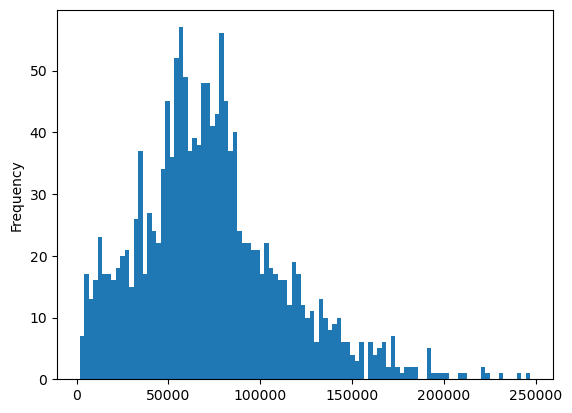

In [40]:
# Distribution of volume lengths
#   Note removal of long volumes from vis
metadata.loc[metadata.words.between(0,250000)].words.plot.hist(bins=100);

<Axes: ylabel='Frequency'>

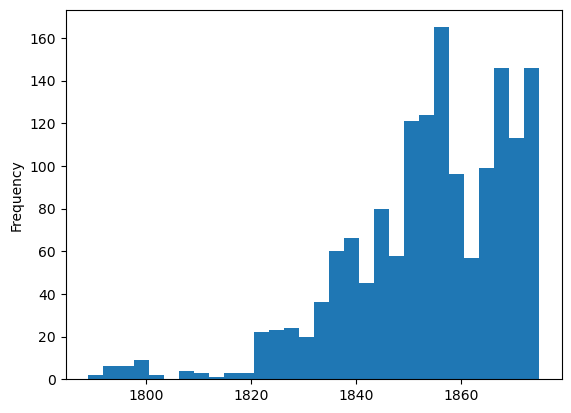

In [41]:
metadata.loc[metadata.pub_date.between(1700, 1900)].pub_date.plot.hist(bins=30)

### Data Cleaning
As can be seen from above, the corpus includes some very long and very short volumes. I avoid the outliers by removing the volumes with fewer than 50,000 words and more than 150,000 words.

In [42]:
filtered_metadata = metadata[(metadata['words'] > 50000) & (metadata['words'] < 150000)]
filtered_metadata = filtered_metadata.copy()
filtered_metadata['pub_date'] = filtered_metadata['pub_date'].astype(int)
filtered_metadata.head()

,author,title,pub_place,publisher,pub_date,gender,gender_guess,ethnicity,occupation,occupation_free,state_born,state_main,state_died,born,died,words
source_id,,,,,,,,,,,,,,,,
eaf002,"Bacon, Delia Salter",Tales of the puritans,New Haven [Conn.],A. H. Maltby,1831,F,0.0,White,Education,Teacher,OH,CT,CT,1811.0,1859.0,70010
eaf006,"Bennett, Emerson",The bandits of the Osage,Cincinnati,Robinson & Jones,1847,M,0.0,White,Writer,Writer,MA,NY,PA,1822.0,1905.0,104654
eaf007,"Bennett, Emerson","Kate Clarendon, or, Necromancy in the wilderness",Cincinnati,Stratton and Barnard,1848,M,0.0,White,Writer,Writer,MA,NY,PA,1822.0,1905.0,71261
eaf008,"Bennett, Emerson",The renegade,Cincinnati,Robinson & Jones,1848,M,0.0,White,Writer,Writer,MA,NY,PA,1822.0,1905.0,82322
eaf009,"Bennett, Emerson","The trapper's bride, or, Spirit of adventure",Cincinnati,Stratton & Barnard,1848,M,0.0,White,Writer,Writer,MA,NY,PA,1822.0,1905.0,113704


In [43]:
def create_df(metadata):
    texts = []
    titles = []
    for index, row in metadata.iterrows():
        for name in os.listdir(text_dir):
            if row.name == name:
                file_path = os.path.join(text_dir, name)
                titles.append(row['title'])
                with open(file_path, "r", encoding="utf-8") as f:
                    text = f.read()
                    texts.append(text)
    data = pd.DataFrame({'Title': titles, 'Content': texts})
    return data

Since I want to explore how the descriptions of body parts of different genders change in the 19th century, I decided to compare the body part descriptions from an early and a late decade of 19th century. Specifically, I will be examining fictional works from 1825 to 1835 and from 1865 to 1875. These particular decades were selected based on the dataset's availability.

Looking at the frequency graph for publication date, we could see that prior to 1825, there were only a few volumes available, and the limited sample size could potentially impact the representativeness of the results. Conversely, the decade of 1865 to 1875 was chosen for similar reasons and produces a reasonably substantial sample size of 272 volumes, as indicated below.

This time span of 30 years, representing one third of a century between the chosen decades, allows for a comprehensive examination of language and social ideology development over this period.

In [44]:
metadata_early = filtered_metadata[(filtered_metadata['pub_date'] >= 1825) & (filtered_metadata['pub_date'] < 1835)]
metadata_late = filtered_metadata[(filtered_metadata['pub_date'] >= 1865) & (filtered_metadata['pub_date'] < 1875)]

data_early = create_df(metadata_early)
data_late = create_df(metadata_late)

In [45]:
print(f"Count of volumes in the early 1800s: {len(data_early)}")
print(f"Count of volumes in the late 1800s: {len(data_late)}")

Count of volumes in the early 1800s: 71
Count of volumes in the late 1800s: 272


### Investigate body parts mentioned in the corpus

In [47]:
# Helper function: Identify whether a noun is a body part
with open("bp_list.txt", 'r') as file:
    body_part_list = [line.strip() for line in file]

def is_body_part(word):
    return word.lower() in body_part_list

https://stackoverflow.com/questions/73117109/how-to-identify-body-part-names-in-a-text-with-python

In [48]:
# Load spaCy model
def spacy_body_part(nlp, text):
    # Get rid of unwanted linebreaks
    cleaned_text = ' '.join(text.split())
    doc = nlp(text)

    bp_name = []
    bp_sent = []
    bp_des = []
    bp_pronoun = []
    for sent in doc.sents:
        for token in sent:
            lem = token.lemma_
            person_name = None
            person_pnoun = None
            if not token.is_punct:
                if token.pos_ == "PRON":
                    person_pnoun = token.text
                if token.pos_ != "NOUN":
                    continue
                if token.ent_type_ == "PERSON":
                    person_name = token.text
                # Check if the noun in the sentence is a body part
                if is_body_part(lem):
                    pronoun = []
                    description = []
                    
                    # Check if there is a gender pronoun as indicator
                    for child in token.children:
                        if child.pos_ in ["ADJ", "VERB"]:
                            description.append(child.text)
                        if child.pos_ == "PRON":
                            pronoun.append(child.text)
                        if child.ent_type_ == "PERSON":
                            pronoun.append(child.text)
                    if pronoun == []:
                        if person_name is not None:
                            pronoun.append(person_name)
                        elif person_pnoun is not None:
                            pronoun.append(person_pnoun)
                    # Ensure only body parts with pronouns indicated is stored
                    if pronoun:
                        bp_name.append(lem)
                        bp_sent.append(sent.text)
                        bp_des.append(description)
                        bp_pronoun.append(pronoun)
    
    bp_df = pd.DataFrame({"Body Part": bp_name, "Description": bp_des, "Person":bp_pronoun,  "Sentence": bp_sent})
    return bp_df

In [49]:
# Helper function: Run the spacy model and return mentioned gendered body parts
def run_spacy(dataset):
    dfs_list = []
    for index, row in dataset.iterrows():
        title = row['Title']
        content = row['Content']
        result_df = spacy_body_part(nlp, content)
        dfs_list.append(result_df)
        final_df = pd.concat(dfs_list, ignore_index=True)
    return final_df

In [50]:
nlp = spacy.load('en_core_web_lg')

In [51]:
# Run on early 1800s data
early_df = run_spacy(data_early)

KeyboardInterrupt: 

In [ ]:
# Run on late 1800s data
sample_late = data_late.sample(n=70, random_state=42)
late_df = run_spacy(sample_late)

In [ ]:
# Take a glance at the result
early_df

,Body Part,Description,Person,Sentence
0,foot,[],[your],"Ah! on your feet, to be sure, replied the\ncou..."
1,finger,"[little, rosy]",[her],"Don't be afraid, answered Alice Weldon, as\nsh..."
2,forehead,[],[her],The complexion of the young\nlady was exceedin...
3,eye,"[large, blue]",[her],The face was not\none of perfect beauty; and y...
4,head,[],[her],"And in fine company, truly, replied Miss\nWeld..."
...,...,...,...,...
24303,heel,[],[his],"`Egad, Charles, said he, thrusting his hands i..."
24304,forehead,[],[his],Fritz touched his forehead significantly and\n...
24305,head,[],[his],Fritz touched his forehead significantly and\n...
24306,hand,[],[his],"II. 10\npreach, the proper arrangements were m..."


In [ ]:
# Take a glance at the result
late_df

,Body Part,Description,Person,Sentence
0,hand,[own],[my],"If it would interest you, I will give you a po..."
1,hand,[],[his],"Leave this place, leave my home, go away from ..."
2,head,[],[my],"""\nThrowing something over my head, I followed..."
3,hand,[own],[his],"He was passionately fond of flowers, and had p..."
4,hand,[],[my],While I turned over in my mind all the sad det...
...,...,...,...,...
35681,head,[],[her],At length her head fell forward—her arms repos...
35682,arm,[reposed],[her],At length her head fell forward—her arms repos...
35683,knee,[],[his],"With conflicting emotions of fear and doubt, h..."
35684,head,[],[our],"And as was expected, but a short time elapsed ..."


In [ ]:
# Separate by gender indicator

# Load the JSON file
with open('girl_boy_names_1880.json') as file:
    gender_names = json.load(file)

def split_gender(df):
    # Convert 'person' column to lowercase for case-insensitive matching
    indicator = df['Person'].str.lower()
    
        # Extract girl and boy names
    female_names = gender_names['girls']
    male_names = gender_names['boys']
    
    female_df = df[df['Person'].apply(lambda x: any(name in female_names or name in ['she', 'her', 'hers'] for name in x))]
    male_df = df[df['Person'].apply(lambda x: any(name in male_names or name in ['he', 'him', 'his'] for name in x))]
    
    return female_df, male_df

In [ ]:
early_female_df, early_male_df = split_gender(early_df)
late_female_df, late_male_df = split_gender(late_df)

In [ ]:
late_female_df

,Body Part,Description,Person,Sentence
7,hand,[gloved],[her],"Well, I never!""\nUpon which she put up her lin..."
10,hand,[],[her],"""\n""Good-morning, ma'am.""\nReaching the house,..."
13,hand,[],[her],"When she had finished her business, she turned..."
24,nose,[pretty],[her],"""\nAt this the minister gave a pitying smile, ..."
43,heart,[],[Mary],"""\nAt these words Mary's heart fell down two d..."
...,...,...,...,...
35678,face,[],[her],Heaven can require no such sacrifice; it gave ...
35679,eye,[],[her],Heaven can require no such sacrifice; it gave ...
35680,cheek,[pale],[her],"If the birds sang as sweetly as before, their ..."
35681,head,[],[her],At length her head fell forward—her arms repos...


In [ ]:
early_female_counts = early_female_df['Body Part'].value_counts()
early_male_counts = early_male_df['Body Part'].value_counts()

late_female_counts = late_female_df['Body Part'].value_counts()
late_male_counts = late_male_df['Body Part'].value_counts()

In [ ]:
# Helper function: Plotting frequency
def frequency_plot(data1, data2, title):
    plt.figure(figsize=(14, 8))
    # Get unique body part counts
    unique_counts = np.unique(list(data1.index) + list(data2.index))
    
    # Create x-axis positions for bars
    x_positions = np.arange(len(unique_counts))

    # Plot female body part counts
    plt.bar(x_positions - 0.2, [data1.get(part, 0) for part in unique_counts], width=0.4, color='lightcoral', label='Female', alpha=0.7)
    # Plot male body part counts
    plt.bar(x_positions + 0.2, [data2.get(part, 0) for part in unique_counts], width=0.4, color='skyblue', label='Male')

    plt.title(title)
    plt.xlabel('Body Part')
    plt.ylabel('Frequency')
    plt.xticks(x_positions, unique_counts, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [63]:
# Helper function: Calculate the skew scores
def body_part_skew(male, female):
    skew_dic = {}
    common_body_parts = set(male.index) & set(female.index)
    
    for body_part in common_body_parts:
        pct_m = male[body_part] / male.sum()
        pct_f = 0

        # Check if the body part is present in the female dataset
        if body_part in female.index:
            pct_f = female[body_part] / female.sum()
        
        # Calculate the skew score
        if pct_m > pct_f:
            skew = pct_m / pct_f
        elif pct_m < pct_f:
            skew = -pct_f / pct_m
        else:
            skew = 0
        skew_dic[body_part] = skew

    return skew_dic, common_body_parts
        

def plot_skew_score(skew_dic, common_body_parts, date):
    # Convert the dictionary to two lists for plotting
    body_parts, scores = zip(*skew_dic.items())

    # Create a scatter plot with labels
    plt.figure(figsize=(12, 8))
    colors = ['red' if score < 0 else 'blue' for score in scores]
    plt.scatter(scores, np.arange(len(common_body_parts)), color=colors, alpha=0.3)

    # Add labels to each point
    for i, (body_part, score) in enumerate(zip(body_parts, scores)):
        plt.text(score, i, body_part, ha='left', va='center')
    
    # Draw a horizontal line at x=0
    plt.axvline(0, color='black', linestyle='--', linewidth=2)

    # Set labels and title
    plt.xlabel('Skew Score')
    plt.title('Skew Scores of Body Parts in ' + date + ' 1800s')

    # Show plot
    plt.show()

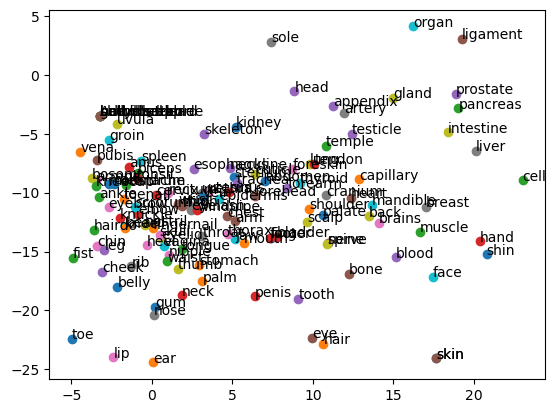

In [ ]:
# load embeddings from model, reduce via PCA, plot some example words

# sample embedding space
pct_to_sample = 100 # how much of the vector space to sample?
tokens_with_vector = []
for string in nlp.vocab.strings: # not all tokens have vectors; get those that do
    if nlp.vocab[string].has_vector:
        tokens_with_vector.append(string)
tokens_in_sample = np.random.choice(tokens_with_vector, int(len(tokens_with_vector) * pct_to_sample/100), replace=False)

# get embeddings
   # pre-allocate numpy array to hold embeddings
embedding_space = np.zeros((len(tokens_in_sample), nlp.vocab.vectors_length), dtype='f')
for i, token in enumerate(tokens_in_sample):
    embedding_space[i] = nlp.vocab[token].vector

# reduce dimensions for plotting
pca = PCA()
pca.fit(embedding_space)

# get vectors for sample words, reduce dimensions, and plot
test_words = body_part_list
# pre-allocate
test_embeddings = np.zeros((len(test_words), nlp.vocab.vectors_length), dtype='f')

# retrieve embeddings
for i, word in enumerate(test_words):
    test_embeddings[i] = nlp.vocab[word].vector
    
# reduce dimensions in learned space
X = pca.transform(test_embeddings)

# plot
fig, ax = plt.subplots()
for i in range(len(test_words)):
    ax.scatter(X[i,0], X[i,1])
    ax.text(X[i,0], X[i,1], test_words[i])
plt.show()

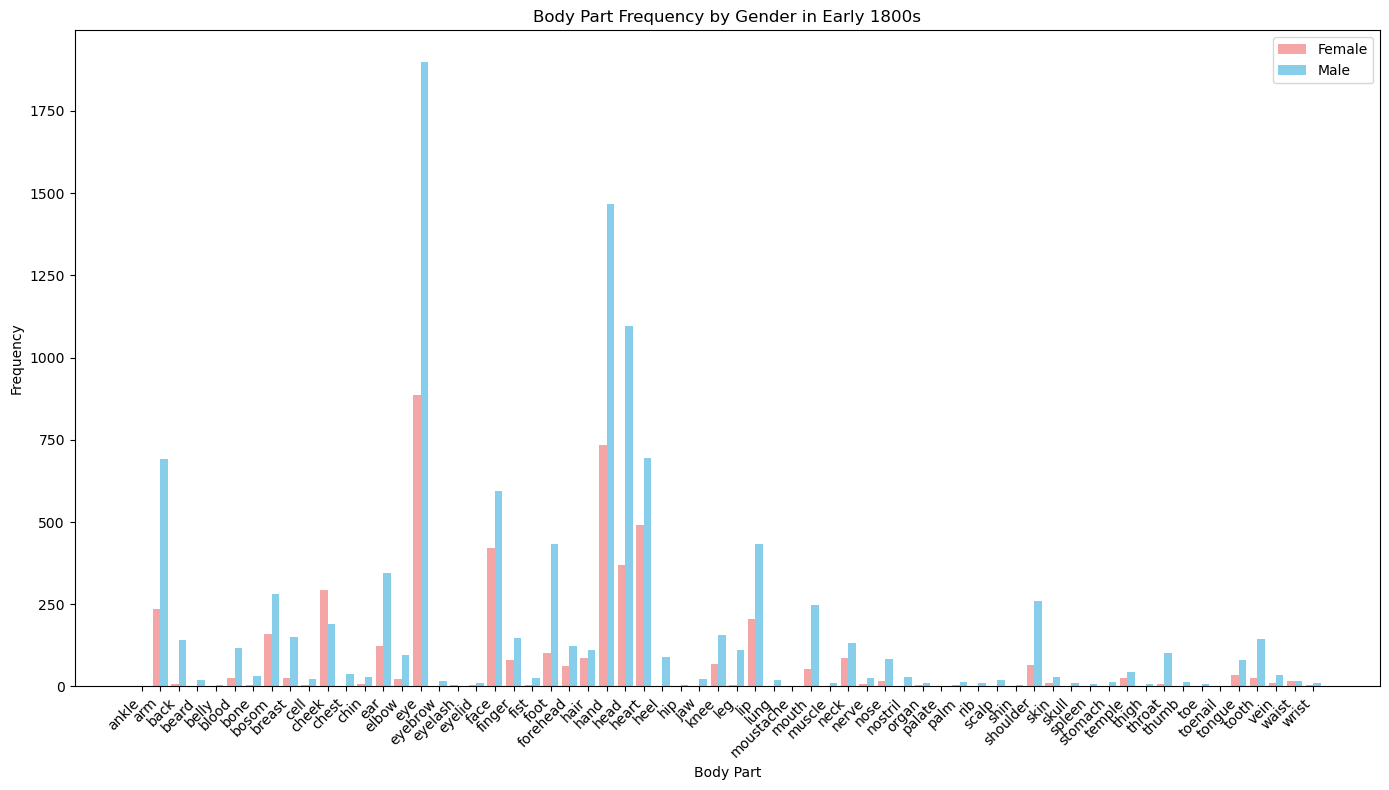

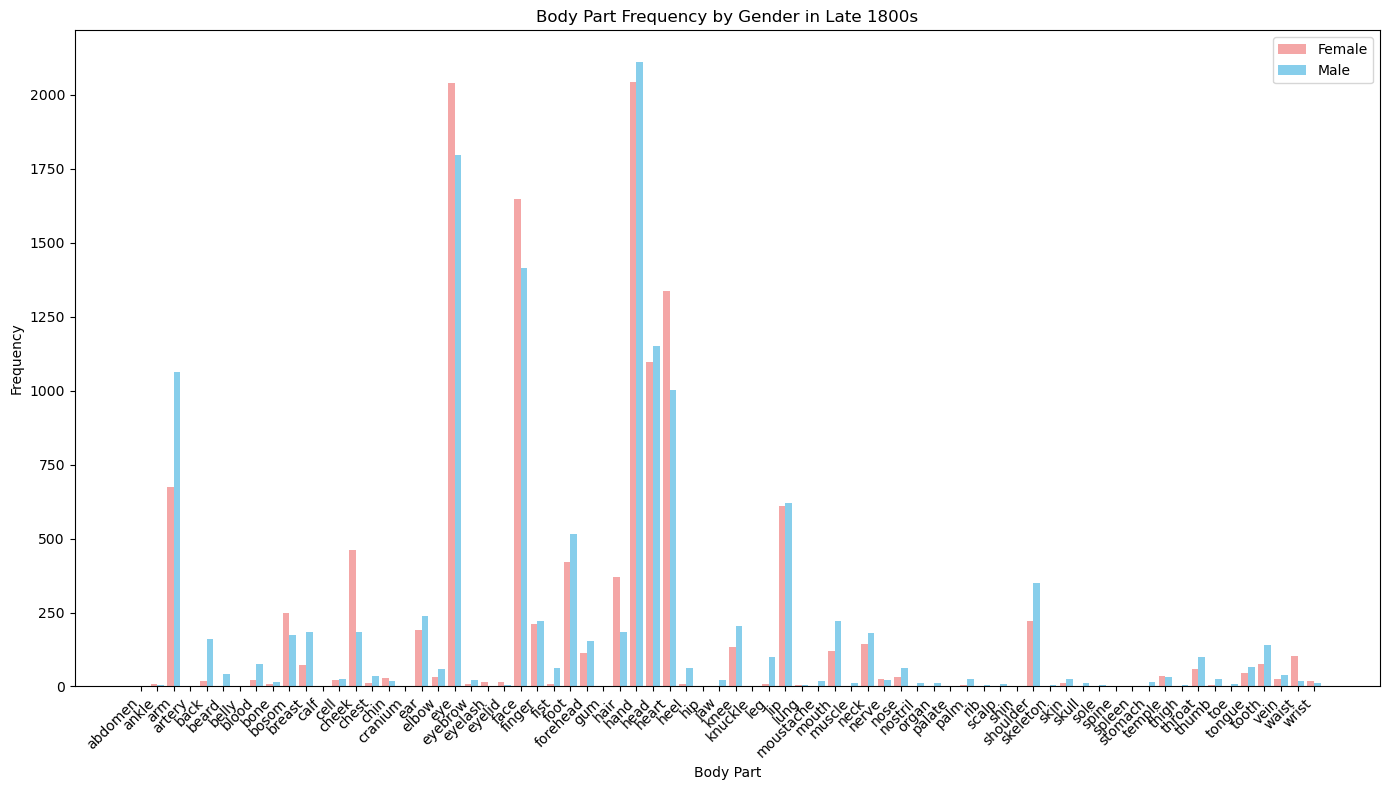

In [53]:
frequency_plot(early_female_counts, early_male_counts, "Body Part Frequency by Gender in Early 1800s")
frequency_plot(late_female_counts, late_male_counts, "Body Part Frequency by Gender in Late 1800s")

{'eye': -1.0676771055364267, 'hip': 1.3117508172902288, 'hair': -1.7765242545616375, 'mouth': 2.008112362271462, 'throat': 4.955503087540864, 'vein': 1.3117508172902288, 'hand': -1.1435098650051922, 'head': 1.299901216411365, 'wrist': 1.20243824918271, 'rib': 5.247003269160915, 'face': -1.6198116131608118, 'foot': 1.8561702741394415, 'skin': 1.1925007429911172, 'finger': -1.236226881086694, 'elbow': 1.9278762011689727, 'shoulder': 1.7291260773371198, 'waist': -2.429958463136033, 'beard': 8.30775517617145, 'organ': 1.6032509989102797, 'spleen': 2.6235016345804576, 'palm': 1.639688521612786, 'knee': 1.0031035661631162, 'chin': 2.1862513621503816, 'leg': 9.79440610243371, 'nerve': 1.6865367650874372, 'neck': -1.4900280059158562, 'thumb': 6.558754086451144, 'tongue': 1.0416844725540053, 'fist': 2.732814202687977, 'ear': 1.2165430966804542, 'bosom': -1.298700489541611, 'eyebrow': 6.996004358881221, 'ankle': -1.143509865005192, 'cheek': -3.5147882166475375, 'bone': 2.8858517980385034, 'eyela

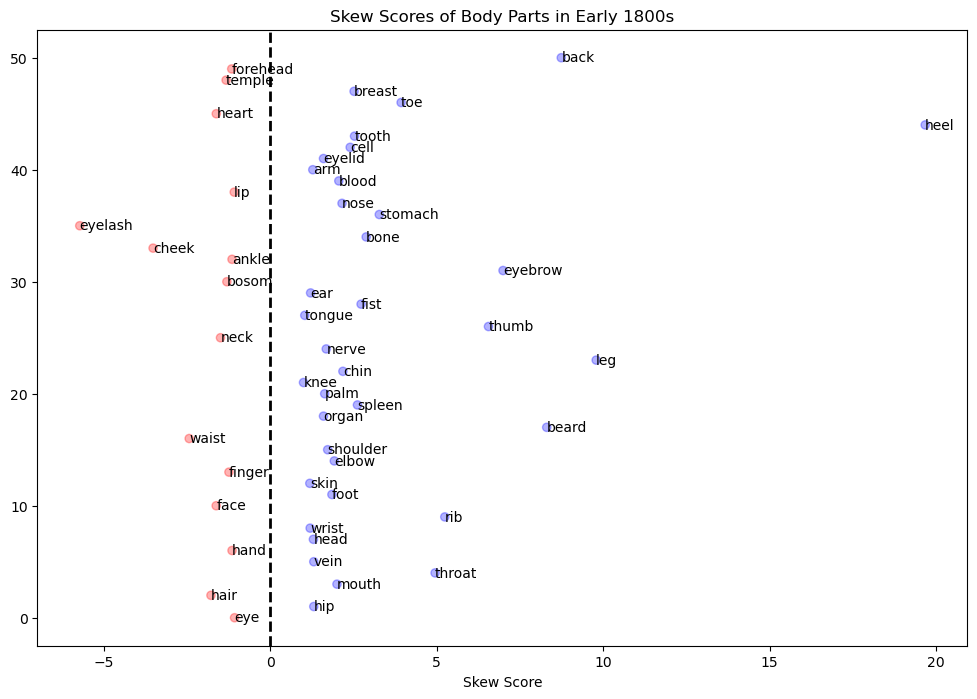

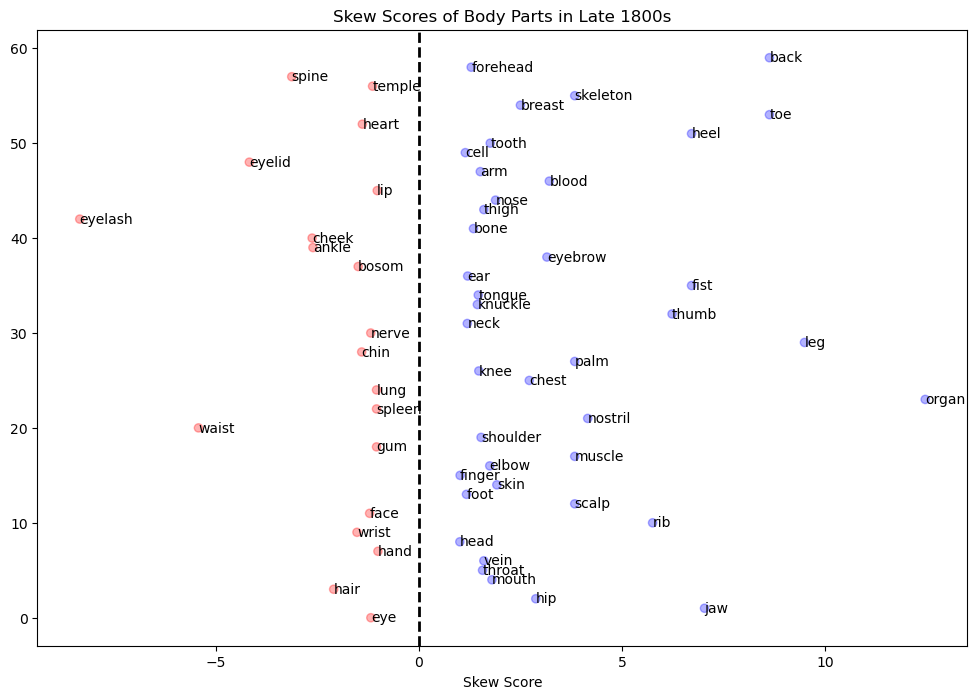

In [66]:
ss_early, bp_early = body_part_skew(early_male_counts, early_female_counts)
print(ss_early)
plot_skew_score(ss_early, bp_early, "Early")

ss_late, bp_late = body_part_skew(late_male_counts, late_female_counts)
plot_skew_score(ss_late, bp_late, "Late")

### Predicting the historial period

In [77]:
# Split the data
data_early['Label'] = "Early"
sample_late['Label'] = "Late"
merged_df = pd.concat([data_early, sample_late], ignore_index=True)
merged_df = shuffle(merged_df)
merged_df

,Title,Content,Label
121,Three years in a man-trap,THREE YEARS IN A MAN-TRAP.\nCHAPTER I.\nA SHAR...,Late
72,Cottage piety exemplified,COTTAGE PIETY EXEMPLIFIED.\nCHAPTER I.\nMARY'S...,Late
122,"Ravenia, or, The outcast redeemed","RAVENIA;\nOR, THE OUTCAST REDEEMED.\nCHAPTER I...",Late
79,Michael Rudolph,"MICHAEL RUDOLPH.\n""THE BRAVEST OF THE BRAVE.""\...",Late
98,Idolatry,IDOLATRY.\nI.\nTHE ENCHANTED RING.\nONE of the...,Late
...,...,...,...
129,Mliss,MLISS.\nA STORY OF CALIFORNIA IN 1863.\nCHAPTE...,Late
0,Tales of the puritans,THE REGICIDES\nWe dig no lands for tyrants but...,Early
47,"John Bull in America, or, The new Munchausen","1\nJOHN BULL IN AMERICA;\nOR,\nTHE NEW MUNCHAU...",Early
25,Poems and prose writings,Poems.\nTHE BUCCANEER.\nBoy with thy blac berd...,Early


In [91]:
# Encode labels using LabelEncoder
# label_encoder = LabelEncoder()
# merged_df['Label'] = label_encoder.fit_transform(merged_df['Label'])

# For the model, we need the labels and the text
text_label = merged_df['Label'].tolist()
text_content = merged_df['Content'].tolist()

train_texts, test_texts, train_labels, test_labels = train_test_split(text_content, text_label, test_size=0.2, random_state=42)

#### Run a Baseline Model

In [118]:
# Vectorize the data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# # Run a logistic regression as a baseline
# log_clf = LogisticRegression().fit(X_train, train_labels)
# log_pred = log_clf.predict(X_test)

# # Examine the performance
# print(f"Performance of Logistic Regression: \n{classification_report(test_labels, log_pred)}")

Performance of Logistic Regression: 
              precision    recall  f1-score   support

           0       1.00      0.69      0.81        16
           1       0.72      1.00      0.84        13

    accuracy                           0.83        29
   macro avg       0.86      0.84      0.83        29
weighted avg       0.88      0.83      0.83        29



In [120]:
# Standard-scale the feature matrix
scaled_train_fm = StandardScaler().fit_transform(X_train.toarray())

# Select the 300 most informative features
selector = SelectKBest(mutual_info_classif, k=20)
selected_fm = selector.fit_transform(scaled_train_fm, train_labels)

# Calculate a 5-fold cross-validated accuracy score
train_cross_val = cross_val_score(LogisticRegression(), selected_fm, train_labels, cv=5, scoring='accuracy')
# Print the resulting cross-validated score
mean_accuracy = np.mean(train_cross_val)
print(f"Mean Cross-Validated Accuracy Score: {mean_accuracy:.4f}")

Mean Cross-Validated Accuracy Score: 0.9818


In [112]:
# Store the predicted results of logistic regression
log_pred_labels = log_pred

# Store correctly classified
correct_log = []
for _true_label, _predicted_label, _text in list(zip(test_labels, log_pred_labels, test_texts)):
  if _true_label == _predicted_label:
    correct_log.append({
            'true_label': _true_label,
            'predicted_label': _predicted_label,
            'fiction_text': _text
    })

# Store incorrectly classified
incorrect_log = []
for _true_label, _predicted_label, _text in list(zip(test_labels, log_pred_labels, test_texts)):
  if _true_label != _predicted_label:
    incorrect_log.append({
            'true_label': _true_label,
            'predicted_label': _predicted_label,
            'fiction_text': _text
    })

In [113]:
print(f"Correctly classified by Logistic Regression: {len(correct_log)}")
print(f"Incorrectly classified by Logistic Regression: {len(incorrect_log)}")

Correctly classified by Logistic Regression: 24
Incorrectly classified by Logistic Regression: 5


In [121]:
# Write function returning a word embedding vector

def get_doc_embedding(text, nlp):
    # Process the input text using spaCy
    doc = nlp(text)

    # Initialize variables to store the sum of word vectors and the count of non-stopword tokens
    sum_vectors = np.zeros(doc.vector.shape)
    count = 0

    # Iterate through the tokens
    for token in doc:
        # Remove any token that spaCy tags that is stop word, punct, space or does not have a vector
        if not token.is_stop and not token.is_punct and not token.is_space and token.has_vector:
            # Add the word vector to the sum
            sum_vectors += token.vector
            count += 1

    # Calculate the average word vector by dividing the sum by the count
    if count > 0:
        avg_vector = sum_vectors / count
        return avg_vector
    else:
        return None

# Verify the function
text = "The bad cat is drinking my coffee."
sample = get_doc_embedding(text, nlp)
print("Length of sample vector",len(sample))
print(sample)

Length of sample vector 300
[ 0.16729254 -0.35514995 -2.96772498 -3.27446991  0.55169549 -1.58315009
  1.28162497  1.72493504  0.73641251  2.35216498  4.934075    2.00435297
  0.083515    1.638905    0.9008     -0.39010003  1.72735253 -4.77294999
  2.53219998 -1.33121499 -1.30861245  3.53570008 -0.58496499 -2.29763754
 -2.57737258 -1.75187474 -4.74695003  2.45248249  0.35339753  1.99909988
  2.19147509 -1.73141996 -2.66634262  0.27938749  0.66905001 -4.77825004
  0.93020001  0.22378497  3.0221626   0.653025   -1.91170246 -0.04110998
  4.22717506 -0.87748757 -1.70349997 -0.280795    1.70717493 -4.59971261
 -0.60865674  1.25380009  0.85692318  3.4623      0.91808498 -1.82337505
 -0.43265502  1.74186751  2.89938753  1.60736999  1.99937496  1.39762
  0.491185   -1.60229502  2.13829003  0.15654999 -2.00425005 -0.37837502
 -4.94034988 -2.66477005  0.68795751 -0.26739001  2.44800004  0.22214999
 -1.23687497  0.20162502  3.13799999  1.17469996 -1.14038251 -0.09569249
  1.95851501 -1.02240753 -

In [ ]:
# Pass each text into the function
embeddings = []
for review in sample_df['content']:
    embedding = get_doc_embedding(review, nlp)
    embeddings.append(embedding)
    
# Store as a feature matrix
embed_fm = np.array(embeddings)

# Print the shape
print("Shape of the feature matrix:", embed_fm.shape)

In [ ]:
# Compute a 10-fold cross-validated logistic regression classification score
log_reg = LogisticRegression(max_iter=1000)  # Increase max_iter to avoid ConvergenceWarning
embed_cross_val = cross_val_score(log_reg, embed_fm, gold_labels, cv=5, scoring='accuracy')

# Print the cross-validated classification score
print(f"10-fold Cross-Validated Classification Score: {embed_cross_val.mean():.4f}")

#### Set Parameters for BERT Model

In [99]:
# Name of the BERT model that we want to use
model_name = 'distilbert-large-cased'

# Use GPU
device_name = 'cpu'

# Maximum number of tokens in any document sent to BERT
max_length = 512

# Name of the directory where we'll save our model. You can name it whatever you want.
cached_model_directory_name = 'distilbert-decade-classify'

In [108]:
# imports from transformers
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [111]:
# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /distilbert-large-cased/resolve/main/tokenizer_config.json (Caused by ProxyError('Cannot connect to proxy.', TimeoutError('_ssl.c:990: The handshake operation timed out')))' thrown while requesting HEAD https://huggingface.co/distilbert-large-cased/resolve/main/tokenizer_config.json


ProxyError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /distilbert-large-cased/resolve/main/tokenizer_config.json (Caused by ProxyError('Cannot connect to proxy.', TimeoutError('_ssl.c:990: The handshake operation timed out')))

In [ ]:

# Create a map for labels
unique_labels = set(label for label in train_labels)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}
print(label2id.keys())
print(id2label.keys())

In [ ]:
# Pass training/testing sentences to tokenizer, truncate them if over max length, and add padding (max is 512)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in train_labels]
test_labels_encoded  = [label2id[y] for y in test_labels]

## 3. Results

In [ ]:
# Original BERT model: 

## 4. Discussion and conclusions